In [ ]:
import torch
from torch import nn
import torchvision
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torch.nn import functional as F

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model_path = '/content/drive/My Drive/ViT_Models/UnfrozenViT80percent.pth'
img_path = '/content/drive/MyDrive/Reverse/37/16.png'

In [ ]:
# Create the model architecture
from torchvision.models import vit_b_16
model = vit_b_16()
model.heads.head = nn.Linear(in_features=768, out_features=60)

# Load the state dictionary
state_dict = torch.load(model_path)

# Rename keys
from collections import OrderedDict

new_state_dict = OrderedDict()
for key, value in state_dict.items():
    # Rename "heads.weight" -> "heads.head.weight" and "heads.bias" -> "heads.head.bias"
    if key == "heads.weight":
        new_state_dict["heads.head.weight"] = value
    elif key == "heads.bias":
        new_state_dict["heads.head.bias"] = value
    else:
        new_state_dict[key] = value


# Load the updated state_dict into the model
model.load_state_dict(new_state_dict)
model.eval()

<ipython-input-15-73ad7758d553>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path)


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [ ]:
#Preprocessing with ViT_B16 transforms
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

def preprocess_image(img_path):
    preprocess =  pretrained_vit_weights.transforms()
    img = Image.open(img_path).convert('RGB')
    return preprocess(img).unsqueeze(0)  # Add batch dimension

In [ ]:
# Hook to capture the attention scores
attention_scores = []

def attention_hook(module, input, output):
    # Compute Q, K, and V from input using in_proj_weight
    in_proj_weight = module.in_proj_weight  # Shape: [3 * d_model, d_model]
    in_proj_bias = module.in_proj_bias if module.in_proj_bias is not None else 0

    # Split in_proj_weight into Q, K, V weights
    d_model = in_proj_weight.shape[1]  # Example: 768
    q_weight, k_weight, v_weight = in_proj_weight.chunk(3, dim=0)
    q_bias, k_bias, v_bias = in_proj_bias.chunk(3, dim=0) if in_proj_bias is not None else (0, 0, 0)

    # Inputs to the self-attention layer
    x = input[0]  # Shape: [batch_size, seq_len, d_model]

    # Compute Q, K, V
    Q = torch.matmul(x, q_weight.T) + q_bias
    K = torch.matmul(x, k_weight.T) + k_bias
    V = torch.matmul(x, v_weight.T) + v_bias

    # Compute raw attention scores (QK^T / sqrt(d_k))
    d_k = K.shape[-1]
    attention_raw = torch.matmul(Q, K.transpose(-2, -1)) / (d_k ** 0.5)

    # Apply softmax to get normalized attention scores
    attention = torch.softmax(attention_raw, dim=-1)  # Shape: [batch_size, seq_len, seq_len]

    # Save the attention scores for visualization
    attention_scores.append(attention)

# Attach hook to the self-attention module
model.encoder.layers.encoder_layer_0.self_attention.register_forward_hook(attention_hook)

# Forward pass with an image tensor
image_tensor = preprocess_image(img_path)
with torch.no_grad():
    _ = model(image_tensor)

# The `attention_scores` list now contains the attention maps
print(f"Captured attention map shape: {attention_scores[0].shape}")

Captured attention map shape: torch.Size([1, 197, 197])


In [ ]:
print(f"Attention map shape: {attention_scores[0].shape}")

Attention map shape: torch.Size([1, 197, 197])


In [ ]:
cls_attention = attention_scores[0][:, 0, 1:]  # Shape: [batch_size, seq_len-1]

In [ ]:
grid_attention = cls_attention.view(1, 14, 14)  # Assuming 14x14 patches

In [ ]:
upsampled_attention = F.interpolate(grid_attention.unsqueeze(1), scale_factor=16, mode="bilinear")

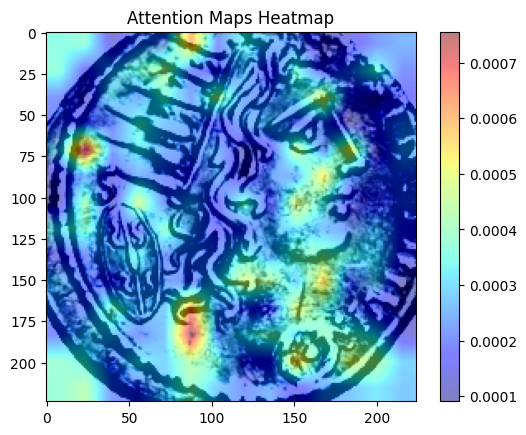

In [ ]:
import matplotlib.pyplot as plt

# Assuming `image_tensor` is your input image of shape [1, 3, 224, 224]
image = image_tensor[0].permute(1, 2, 0).cpu().numpy()  # Convert to HWC format for visualization

plt.title("Attention Maps Heatmap")
plt.imshow(image)  # Original image
plt.imshow(upsampled_attention[0, 0].cpu().detach().numpy(), cmap="jet", alpha=0.5)  # Heatmap
plt.colorbar()
plt.savefig("attention_maps.png")
plt.show()

In [ ]:
print(model.encoder.layers.encoder_layer_0.self_attention.out_proj.weight.shape)

torch.Size([768, 768])


In [ ]:
print(model.encoder.layers.encoder_layer_0.self_attention.in_proj_weight.shape)

torch.Size([2304, 768])
